# Fermionic QAOA for Portfolio Optimization
In this tutorial, we will solve the portfolio optimization using the Femionic Quantum Approximate Optimization Algorithm (FQAOA).

In [2]:
import copy
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import networkx as nx
import qiskit.primitives as qk_pr

import jijmodeling as jm
import ommx.v1
from ommx_pyscipopt_adapter import OMMXPySCIPOptAdapter

import qamomile.core as qm
from qamomile.core.circuit.circuit import ParametricTwoQubitGate
from qamomile.qiskit import QiskitTranspiler
from qamomile.core.circuit.drawer import plot_quantum_circuit
from qamomile.core.converters.fqaoa import FQAOAConverter
from qamomile.core.ising_qubo import IsingModel, qubo_to_ising

rng = np.random.default_rng()

# Portfolio optimization

The portfolio optimization problem is the problem of finding the optimal portfolio in asset investment. 
Here, we use a formulation based on the most well-known Markowitz model. The Markowitz model aims to maximize returns while minimizing risk. 
Risk is given by the variance $\mu_{ij}$ between assets, and return is represented by $h_i$. 
The combination of these two forms the cost function:

$$
C(\boldsymbol{w}) = -\lambda \sum_{1 = i \leq j}^N \sigma_{ij} w_i w_j + (1-\lambda) \sum_{i=1}^N \mu_i w_i.
$$

Here, $\lambda : (0 < \lambda < 1)$ is a parameter that adjusts the balance between return and risk. 
The solution to the portfolio optimization is obtained by solving the minimization problem of this function. The decision variable $w_i$ represents the position for the $i$-th asset. 
When $w_i = 0$, the stock is not held (no position), and when $w_i = \pm 1$, the stock is held in a long or short position. 
Furthermore, if there is a limit on the number of assets that can be held, it can be expressed with the following constraint conditions:

$$
\sum_i w_i = D.
$$

Here, $D$ is the total number of assets that can be held. In this case, the portfolio optimization problem becomes a constrained combinatorial optimization problem.

# Constructing the Mathematical Model

The mathematical model of portfolio optimization is implemented using `JijModeling`. Since QAOA is an algorithm for QUBO, the integer variables $w = \{-1, 0 , 1\}^N$ need to be converted into binary variables $x = \{0,1\}$. Here, two binary variables are used for each variable $w_i$, and $w_i = 1 - x_{i,1} - x_{i,2}$ is used to represent it.

$$
\begin{gather*}
C(\boldsymbol{x}) = -\lambda \sum_{i=1}^N \sigma_{ij} \sum_{1 = d \leq d'}^2 \left(x_{i,d}-\frac{1}{2}\right) \left(x_{j,d'}-\frac{1}{2}\right) + (1-\lambda) \sum_{i=1}^N \mu_i \sum_{d=1}^2 \left( x_{i,d}-\frac{1}{2} \right) \\
{\rm{s.t.}} \quad \sum_{i=1}^N\sum_{d=1}^2 x_{i,d} = N-M 
\end{gather*}
$$

First, we will implement the mathematical model of the portofolio optimization problem using `JijModeling`.

In [4]:
def create_potofolio_optimzation_problem():
    N = jm.Placeholder("N") # The number of decision variables
    D = jm.Placeholder("D") # The number of bits that need to encode an integer variable into binary variables
    M = jm.Placeholder("M")
    lam = jm.Placeholder("lam") # A parameter that adjusts the balance between risk and return
    lam.set_latex("\lambda")
    sigma = jm.Placeholder("sigma", ndim=2) # A covariance matrix that represents the normalized asset returns
    sigma.set_latex("\sigma")
    mu = jm.Placeholder("mu", ndim=1) # A returns vector that represents the normalized average asset 
    mu.set_latex("\mu")
    
    x = jm.BinaryVar("x", shape=(N,D))
    l = jm.Element("l", belong_to=(0,N))
    l_dash = jm.Element("l'", belong_to=(0,N))
    d = jm.Element("d", belong_to=(0,D))
    d_dash = jm.Element("d'", belong_to=(0,D))
    
    problem = jm.Problem("Portfolio Optimization", sense=jm.ProblemSense.MINIMIZE)
    
    problem += -lam * jm.sum([l, l_dash], sigma[l,l_dash] * jm.sum([d, d_dash], (x[l,d]-0.5) * (x[l_dash, d_dash]-0.5))) + (1-lam) * jm.sum(l, mu[l] * jm.sum(d, (x[l,d]-0.5)))
    
    problem += jm.Constraint("the total number of stock holdings", jm.sum([l,d], x[l,d])==N-M)
    
    return problem
    
problem_minimize = create_potofolio_optimzation_problem()
problem_minimize

We will now prepare the problem to be solved and perform compilation using `JijModeling.Interpreter` and `ommx.v1.Instance`.

In [5]:
num_integer = 5
num_bit = 2
num_stock = 3
sigma = rng.uniform(-0.1, 0.1, size=(num_integer, num_integer))
mu = rng.uniform(-1.0, 1.0, size=num_integer)
lam = 0.1

instance_data = {"N": num_integer, "D": num_bit, "M": num_stock, "lam": lam, "sigma": sigma, "mu": mu}
interpreter = jm.Interpreter(instance_data)
instance: ommx.v1.Instance = interpreter.eval_problem(problem_minimize)

# Implementing QAOA using Qamomile

We generate the FQAOA circuit and Hamiltonian from the compiled Instance. The converter used to generate these is `qm.fqaoa.FQAOAConverter`.

In [6]:
num_fermions = num_integer - num_stock # N - M
p = 10
fqaoa_converter = FQAOAConverter(instance, num_fermions=num_fermions, mixer_connectivity='cyclic', normalize_model=False)
fqaoa_circuit = fqaoa_converter.get_fqaoa_ansatz(p)
fqaoa_cost = fqaoa_converter.get_cost_hamiltonian()

# Run QAOA using Qiskit

Here, we generate the Qiskit’s QAOA circuit and Hamiltonian using the `qamomile.qiskit.QiskitTranspiler` converters. By utilizing the two methods,`QiskitTranspiler.transpile_circuit` and `QiskitTranspiler.transpile_hamiltonian`, we can transform the QAOA circuit and Hamiltonian into a format compatible with Qiskit.

In [7]:
qk_transpiler = QiskitTranspiler()
qk_circuit = qk_transpiler.transpile_circuit(fqaoa_circuit)
qk_cost = qk_transpiler.transpile_hamiltonian(fqaoa_cost)

We run QAOA to optimize the parameters. Here, we use the BFGS method as the optimizer.

In [8]:
init_params = [rng.uniform(0.0, 2.0*np.pi) for i in range(2*p)]
estimator = qk_pr.StatevectorEstimator()

cost_history = []
def estinamate_cost(params):
    job = estimator.run([(qk_circuit, qk_cost, params)])
    job_result = job.result()
    cost = job_result[0].data['evs']
    cost_history.append(cost)
    return cost

result = opt.minimize(estinamate_cost, init_params, method="BFGS")
result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.738592496278632
        x: [ 4.847e+00  6.180e+00 ...  5.668e+00 -4.581e+00]
      nit: 202
      jac: [ 5.960e-07  7.823e-07 ...  2.310e-07  2.757e-07]
 hess_inv: [[ 1.537e+01 -1.015e+01 ...  3.121e+00 -1.027e+01]
            [-1.015e+01  1.859e+01 ... -2.376e+01  4.800e+01]
            ...
            [ 3.121e+00 -2.376e+01 ...  4.190e+02 -3.835e+02]
            [-1.027e+01  4.800e+01 ... -3.835e+02  5.629e+02]]
     nfev: 4452
     njev: 212

# Result Visualization

We visualize the optimization process. We plot the changes in the cost function and the approximation ratio. The approximation ratio is an indicator of how close the algorithm's solution $\boldsymbol{x}$ is to the optimal solution $\boldsymbol{x}^*$.

$$
{\rm{AR}} = \frac{C_{\max} - C(\boldsymbol{x})}{C_{\max} - C(\boldsymbol{x}^*)}
$$

Here, $C_{\max}$ is the maximum energy value. First, we compute the maximum and minimum energy of the transformed Ising Hamiltonian by brute-force search.

In [9]:
num_qubits = num_integer * num_bit
ising = fqaoa_converter.ising

energy_list = []
state_list = []
for id_list in combinations(np.arange(num_qubits), num_fermions):
    state = [-1 if x in id_list else 1 for x in range(num_qubits)]
    objective_value = ising.calc_energy(state) - ising.constant
    energy_list.append(objective_value)
    state_list.append(state)

energy_list = np.array(energy_list)
min_energy = energy_list.min()
max_energy = energy_list.max()

Using the obtained maximum and minimum energy values, we calculate the approximation ratio.

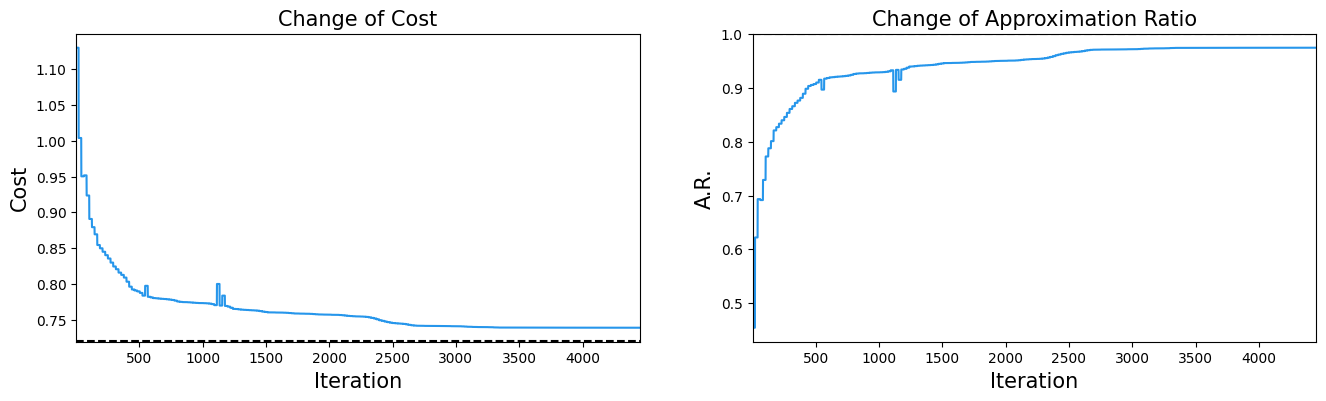

In [10]:
approx_ratio = 1.0 - np.abs(np.array(cost_history)-min_energy) / np.abs(max_energy - min_energy)

fig1, ax1 = plt.subplots(1, 2, figsize=(16,4))

ax1[0].plot(cost_history, label="Cost", color="#2696EB")
ax1[0].axhline(min_energy, linestyle="--", color="black")
ax1[0].set_xlim(1, result.nfev)
ax1[0].set_xlabel("Iteration", fontsize=15)
ax1[0].set_ylabel("Cost", fontsize=15)
ax1[0].set_title("Change of Cost", fontsize=15)

ax1[1].plot(approx_ratio, label="AR", color="#2696EB")
ax1[1].axhline(1.0, linestyle="--", color="black")
ax1[1].set_xlim(1, result.nfev)
ax1[1].set_xlabel("Iteration", fontsize=15)
ax1[1].set_ylabel("A.R.", fontsize=15)
ax1[1].set_title("Change of Approximation Ratio", fontsize=15)

plt.show()

# Evaluating the Results

From the job counts obtained earlier, we can transfer them to a sampleset by `qm.fqaoa.FQAOAConverter.decode`.
The sampleset can select only the feasible solutions and then we examine the distribution of the objective function values.

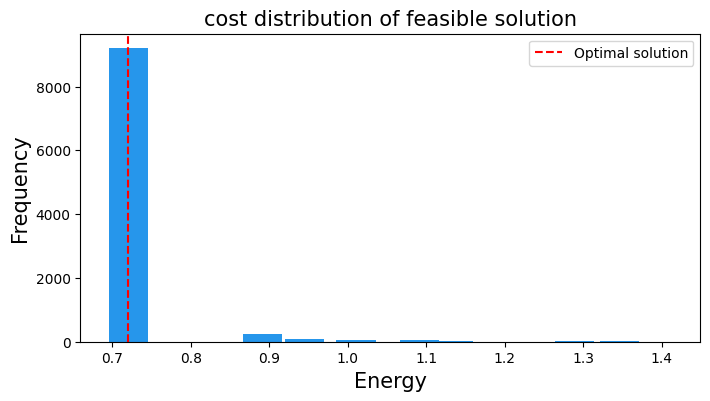

In [16]:
solution = OMMXPySCIPOptAdapter.solve(instance)
min_objective = solution.objective

num_samples = 10000
sampler = qk_pr.StatevectorSampler()
qk_circuit.measure_all()
job = sampler.run([(qk_circuit, result.x)], shots=num_samples)
job_result = job.result()[0]
qaoa_counts = job_result.data["meas"]

sampleset = fqaoa_converter.decode(qk_transpiler, job_result.data["meas"])
plot_data = {}
energies = []
frequencies = []
for entry in sampleset.raw.objectives.entries:
    energies.append(entry.value)
    frequencies.append(len(entry.ids))

fig2, ax2 = plt.subplots(figsize=(8,4))
ax2.bar(energies, frequencies, width=0.05, color='#2696EB')
ax2.axvline(min_objective, linestyle="--", color="red", label='Optimal solution')
ax2.set_title("cost distribution of feasible solution", fontsize=15)
ax2.set_ylabel("Frequency", fontsize=15)
ax2.set_xlabel("Energy", fontsize=15)
ax2.legend()
plt.show()

Of course, `ommx.v1.SampleSet` can be used to verify whether the samples satisfy the constraints of the original problem. The output states of FQAOA all satisfy the constraints.

In [12]:
df_sampleset = sampleset.summary
print(f"feasible solutions: {(df_sampleset['feasible'] == True).sum()}/{num_samples}")
print(f"infeasible solutions: {(df_sampleset['feasible'] == False).sum()}/{num_samples}")

feasible solutions: 10000/10000
infeasible solutions: 0/10000
